In [93]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
from keras.preprocessing import image

from tensorflow.keras.applications import ResNet50 
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
import time
from sklearn.metrics import classification_report



In [94]:
from PIL import Image

In [95]:
dataset = './dataset/images/'
imageLabels = './dataset/imageLabels.txt'
model_folder = './models/'
logs_folder = './logs/'

In [96]:
# Dataset settings
train_vol = 0.8

# Train settings
batch_size = 256
epochs = 20

In [97]:
categories = [
    "Pepperoni",
    "Bacon",
    "Mushrooms",
    "Onions",
    "Peppers",
    "Black olives",
    "Tomatoes",
    "Spinach",
    "Fresh basil",
    "Arugula",
    "Broccoli",
    "Corn",
    "Pineapple"
]

In [98]:
with open(imageLabels, 'r') as file:
    lines = file.readlines()
    y = []
    for line in lines:
        class_array = [int(num) for num in line.split()]
        y.append(class_array)
     
    y1=y
    y= np.array(y)    
        

print(y[0])


[0 0 0 1 1 0 0 0 0 0 0 0 0]


In [99]:
y.shape

(9213, 13)

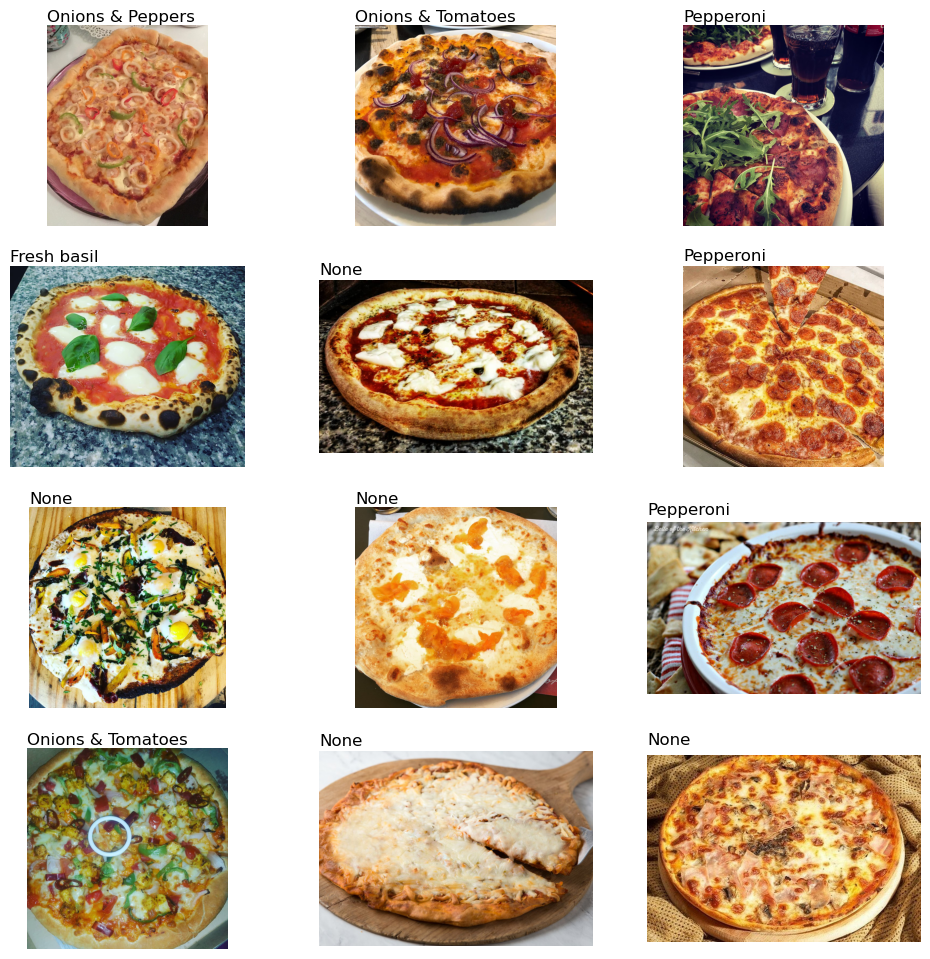

In [100]:
def plot_images():
    
    plt.figure(figsize=(12, 12))
    indexes = [random.randint(0, 9213) for _ in range(12)]
    for i, index in enumerate(indexes):
        j= '{:05d}'.format(index)
        img_path = dataset+"/"+str(j)+'.jpg'
        img = image.load_img(img_path)
        img_arr = image.img_to_array(img)/255.0
        
        cat = []
        for k, label in enumerate(y[index-1]):
            if label == 1: 
                cat.append(categories[k])
                
                
        # Join categories into a single string
        if cat ==[]:
            cat_str = 'None'
        else :
            cat_str = ' & '.join(cat)        
        
        # Create Subplot and plot the images
        plt.subplot(4, 3, i+1)
        plt.imshow(img_arr)
        plt.axis('off')
        plt.text(0, -20, cat_str, fontsize=12, ha='left')
        
    plt.show()

        
plot_images()        
        
       

In [101]:
image_names = ['{:05d}'.format(i) for i in range(1,9214)]

In [102]:
data_x = [tf.constant(np.array(Image.open(dataset + img + '.jpg').resize((150, 150)))) for img in image_names]

In [103]:
four_channel_images = []
for i in range(0,9213):
    if data_x[i].shape[2] == 4:
        four_channel_images.append(i)
print(four_channel_images)        

[3155, 3158, 3162, 3166, 3171, 3172, 3175, 3178, 3181, 3204, 3231, 3290, 3299, 3307, 3447, 3452, 3457, 3466, 3472, 3475, 3586, 3598, 3659, 3676, 3721, 3727, 3796, 3801, 3807, 3824, 3850]


In [104]:
#fixing 4 channel problem
for i in four_channel_images:
    j= '{:05d}'.format(i+1)
    rgba_image = Image.open(dataset + str(j) + '.jpg')
    rgb_image = rgba_image.convert("RGB")
    resized_image = rgb_image.resize((150, 150))
    image_array = np.array(resized_image)
    data_x[i]= image_array

In [105]:
train_dataset = tf.data.Dataset.from_tensor_slices((data_x, y))

In [106]:
def preprocess_data(img, label):
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img, label

In [107]:
train_dataset = train_dataset.map(preprocess_data)

In [108]:
len(train_dataset)

9213

In [109]:
for image, label in train_dataset.take(1):
    input_tensor = tf.keras.Input(shape=image.shape)

In [110]:
input_tensor


<KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'input_10')>

In [111]:
labels = []
for i in range(1,9214):
        j= '{:05d}'.format(i)
        img_path = dataset+"/"+str(j)+'.jpg'
        cat=[]
        for k, label in enumerate(y[i-1]):
            if label == 1: 
                cat.append(categories[k])

        # Join categories into a single string
        if cat ==[]:
            cat_str = 'None'
        else :
            cat_str = ' & '.join(cat)    
            
        labels.append(cat_str)    
       

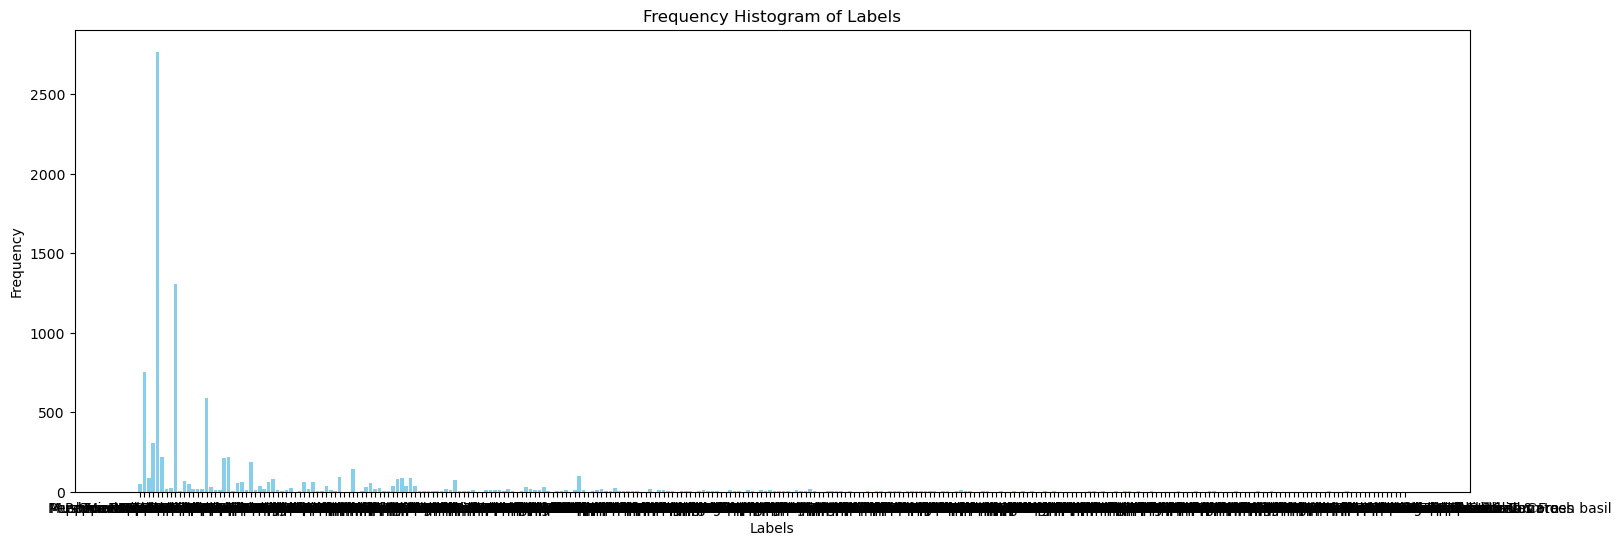

In [112]:
import matplotlib.pyplot as plt
from collections import Counter

# Visualise label distribution

label_counts = Counter(labels)
labels, frequencies = zip(*label_counts.items())

# Plot the histogram
plt.figure(figsize=(18, 6))
plt.bar(labels, frequencies, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency Histogram of Labels')
plt.show()

In [113]:
# Split into train/validate
train_size = int(train_vol * len(train_dataset))

test_dataset = train_dataset.skip(train_size)
train_dataset = train_dataset.take(train_size)

In [117]:
# Batch data
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [118]:
print(train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 13), dtype=tf.int32, name=None))>


In [119]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Layer


In [81]:
class ThresholdingLayer(Layer):
    def __init__(self, **kwargs):
        super(ThresholdingLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.cast(tf.greater(inputs, 0.5), tf.float32)


In [120]:
base_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3),
)

#num_layers_to_train = int(np.ceil(0.2 * len(base_model.layers)))

for layer in base_model.layers :
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(13, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_11[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [121]:
import datetime
for batch in train_dataset:
    print(batch[0].shape)
    print(model.predict(batch[0])[0])
    break

(256, 150, 150, 3)
8/8 [==============================] - 15s 1s/step
[0.5167262  0.53133523 0.3786893  0.49302465 0.5307145  0.50803614
 0.59560806 0.6054442  0.6007605  0.3827007  0.8488126  0.6246732
 0.5224265 ]


In [122]:
# Compile settings
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
loss = tf.keras.metrics.binary_crossentropy

In [123]:
# Compile model
model.compile(optimizer= optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
model_name = f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}-resnet_50.h5'

model_loc = f'{model_folder}{model_name}'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_loc, monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)

logs_loc = f'{logs_folder}{model_name}'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_loc, histogram_freq=1)

# Train model
run_hist = model.fit(train_dataset, validation_data=test_dataset,
                      epochs=epochs, batch_size=batch_size,
                      callbacks=[checkpoint, tensorboard_callback])

Epoch 1/20
29/29 [==============================] - ETA: 0s - loss: 0.3611 - accuracy: 0.2472
Epoch 1: val_accuracy improved from -inf to 0.55996, saving model to ./models\20240228-045340-resnet_50.h5
29/29 [==============================] - 387s 13s/step - loss: 0.3611 - accuracy: 0.2472 - val_loss: 0.2313 - val_accuracy: 0.5600
Epoch 2/20
29/29 [==============================] - ETA: 0s - loss: 0.2641 - accuracy: 0.3349
Epoch 2: val_accuracy did not improve from 0.55996
29/29 [==============================] - 354s 12s/step - loss: 0.2641 - accuracy: 0.3349 - val_loss: 0.2292 - val_accuracy: 0.5594
Epoch 3/20
29/29 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.3275
Epoch 3: val_accuracy did not improve from 0.55996
29/29 [==============================] - 353s 12s/step - loss: 0.2615 - accuracy: 0.3275 - val_loss: 0.2290 - val_accuracy: 0.5572
Epoch 4/20
29/29 [==============================] - ETA: 0s - loss: 0.2614 - accuracy: 0.3204 
Epoch 4: val_accuracy

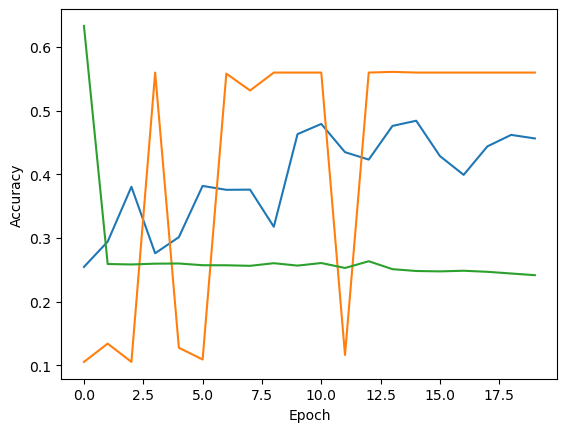

In [45]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.plot(run_hist.history['accuracy'], label='train')
plt.plot(run_hist.history['val_accuracy'], label='test')
plt.plot(run_hist.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()